## Chaitanya Dahale
## 202318017

# PySpark setup

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d4d37db8ce3164da8be49818a63ce3c53c0352325ff9a6407d83ee10844abf32
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# Import data

In [ ]:
from sklearn.datasets import fetch_20newsgroups # importing 20 news group dataset


categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space'] #Features selected for k means
newsgroups = fetch_20newsgroups(subset='all', categories=categories)


# Required libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.sql.functions import col
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_extraction.text import TfidfVectorizer
from pyspark.ml.linalg import Vectors
from gensim.models import Word2Vec
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report


# 1] Performing K-means clustering and Hierarchical clustering on the dataset using PySpark.

In [ ]:
spark = SparkSession.builder.appName("Newsgroups Clustering") .getOrCreate()


In [ ]:
df = spark.createDataFrame([(doc,) for doc in newsgroups.data], ["text"])


In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(df)

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filteredData = remover.transform(wordsData)

cv = CountVectorizer(inputCol="filtered", outputCol="rawFeatures")
cv_model = cv.fit(filteredData)
featurizedData = cv_model.transform(filteredData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)


In [ ]:
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(rescaledData)
clustered = model.transform(rescaledData)


In [ ]:
bkm = BisectingKMeans().setK(4).setSeed(1)
model_bisecting = bkm.fit(rescaledData)
clustered_bisecting = model_bisecting.transform(rescaledData)


In [ ]:
clustered_kmeans_pd = clustered.select("features", "prediction").toPandas()


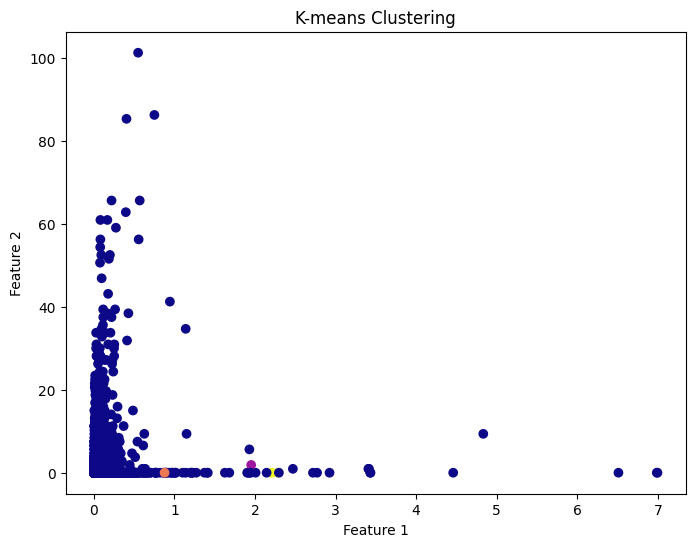

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(clustered_kmeans_pd['features'].apply(lambda x: x[0]),
            clustered_kmeans_pd['features'].apply(lambda x: x[1]),
            c=clustered_kmeans_pd['prediction'], cmap='plasma')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [ ]:
clustered_bisecting_pd = clustered_bisecting.select("features", "prediction").toPandas()


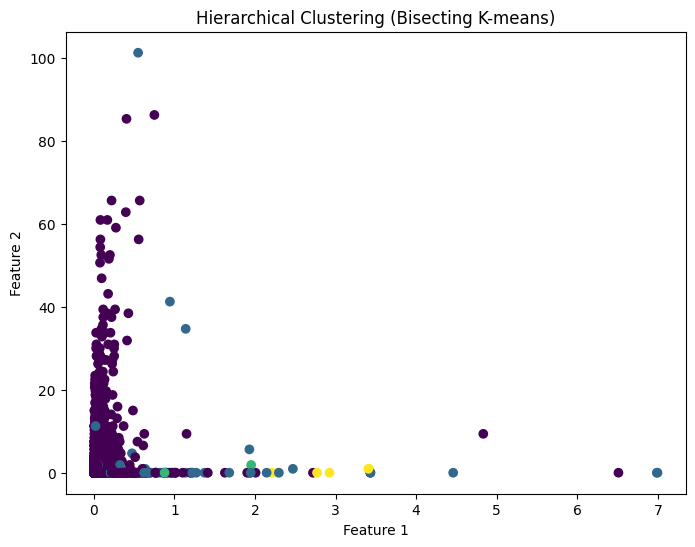

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(clustered_bisecting_pd['features'].apply(lambda x: x[0]),
            clustered_bisecting_pd['features'].apply(lambda x: x[1]),
            c=clustered_bisecting_pd['prediction'], cmap='viridis')
plt.title('Hierarchical Clustering (Bisecting K-means)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


## For Naive-Bayes

In [ ]:
# Data preperation
data = newsgroups.data
target = newsgroups.target

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, target, test_size=0.2, random_state=42)

# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Predictions
nb_predictions = nb_classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, nb_predictions))


              precision    recall  f1-score   support

           0       0.84      0.97      0.90       155
           1       0.96      0.98      0.97       195
           2       0.94      0.98      0.96       201
           3       0.99      0.70      0.82       127

    accuracy                           0.93       678
   macro avg       0.93      0.91      0.91       678
weighted avg       0.93      0.93      0.92       678



In [ ]:
spark.stop()

 # Represent each document using TfIdf matrix.

In [ ]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups = fetch_20newsgroups(subset='all', categories=categories)

newsgroups_df = pd.DataFrame({'text': newsgroups.data, 'target': newsgroups.target})

newsgroups_df.to_csv('newsgroups.csv', index=False)

spark = SparkSession.builder \
    .appName("20 Newsgroups Clustering") \
    .getOrCreate()

newsgroups_path = 'newsgroups.csv'
newsgroups_spark_df = spark.read.csv(newsgroups_path, header=True)



In [ ]:
filtered_df = newsgroups_spark_df.filter(col('text').isNotNull() & (col('text') != ''))

tokenizer = Tokenizer(inputCol="text", outputCol="words")
words_df = tokenizer.transform(filtered_df)


remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_words_df = remover.transform(words_df)

hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=10000)
tf_df = hashingTF.transform(filtered_words_df)

idf = IDF(inputCol="rawFeatures", outputCol="tfidf_features")
idf_model = idf.fit(tf_df)
tfidf_df = idf_model.transform(tf_df)


tfidf_df.show(truncate=False)


+------------------------------------------------------------------------------------------------------+----------------------------------+---------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                  |target                            |words                                                                                                          |filtered_words                                                                                             

In [ ]:
spark.stop()

# For each of the K-means clustering techniques use K(number of clusters) as a hyperparameter and find the WCSS for each k-value. Find the optimal number of clusters using the elbow method.

In [ ]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups = fetch_20newsgroups(subset='all', categories=categories)

newsgroups_df = pd.DataFrame({'text': newsgroups.data, 'target': newsgroups.target})

newsgroups_df.to_csv('newsgroups.csv', index=False)

spark = SparkSession.builder \
    .appName("20 Newsgroups Clustering") \
    .getOrCreate()

newsgroups_path = 'newsgroups.csv'
newsgroups_spark_df = spark.read.csv(newsgroups_path, header=True)



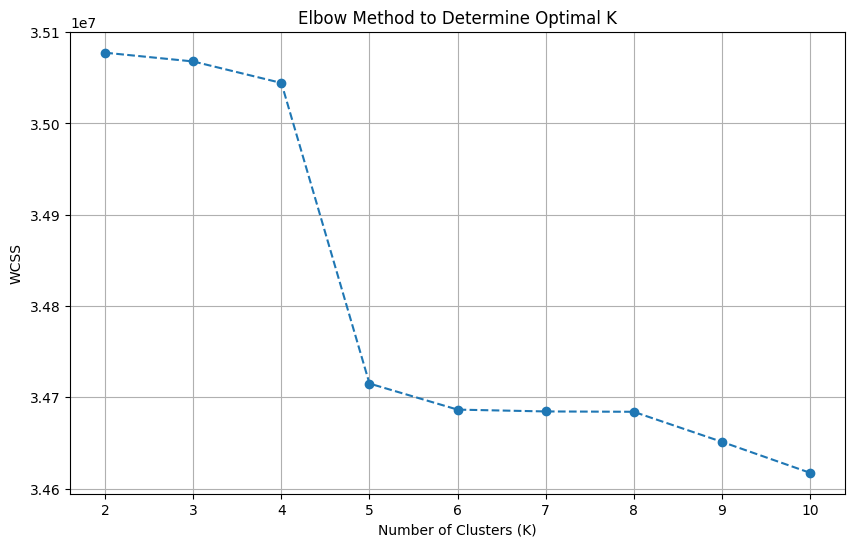

In [ ]:
spark = SparkSession.builder \
    .appName("K-means Clustering with Elbow Method") \
    .getOrCreate()

newsgroups_df = spark.read.text(newsgroups_path)

tokenizer = Tokenizer(inputCol="value", outputCol="words")
words_df = tokenizer.transform(newsgroups_df)


remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_df = remover.transform(words_df)


hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=10000)
tf_df = hashingTF.transform(filtered_df)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(tf_df)
tfidf_df = idf_model.transform(tf_df)

from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

wcss_values = []

max_k = 10

for k in range(2, max_k + 1):
    kmeans = KMeans(featuresCol='features', k=k, seed=1)

    kmeans_model = kmeans.fit(tfidf_df)

    wcss = kmeans_model.summary.trainingCost

    wcss_values.append(wcss)

plt.figure(figsize=(10, 6))
plt.plot(range(2, max_k + 1), wcss_values, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method to Determine Optimal K')
plt.xticks(range(2, max_k + 1))
plt.grid(True)
plt.show()


In [ ]:
spark.stop()

K = 5 is optimal number for K.

---



# Apply Agglomerative clustering for clustering the documents and find the optimal number of clusters using dendrogram diagrams.

In [ ]:

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np

# Load the 20 newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all')

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(newsgroups.data)

# Reduce the dimensionality of the TF-IDF matrix if needed
# For example, you can use TruncatedSVD or PCA for dimensionality reduction

# Compute pairwise distances
distance_matrix = 1 - np.dot(tfidf_matrix, tfidf_matrix.T).toarray()

# Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.title('Dendrogram for Agglomerative Clustering')
plt.show()

# (Additional) Instead of TF-IDF use any semantic-based embeddings like Word2Vec or GloVe etc.

In [ ]:
newsgroups = fetch_20newsgroups(subset='all')

preprocessed_data = [doc.lower().split() for doc in newsgroups.data]

word2vec_model = Word2Vec(preprocessed_data, vector_size=100, window=5, min_count=1, workers=4)

def doc_embedding(doc, model):
    words = [word for word in doc if word in model.wv]
    if len(words) > 0:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

doc_embeddings = np.array([doc_embedding(doc, word2vec_model) for doc in preprocessed_data])

agg_clustering = AgglomerativeClustering(n_clusters=10, linkage='ward')
clusters = agg_clustering.fit_predict(doc_embeddings)




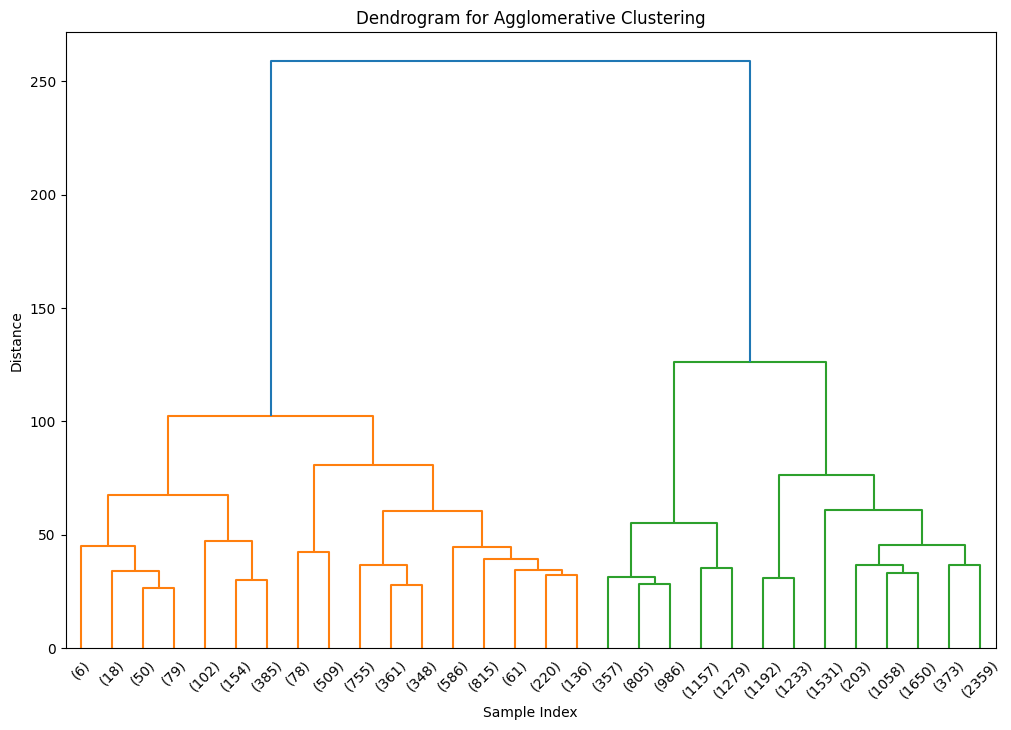

In [ ]:
linkage_matrix = linkage(doc_embeddings, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.title('Dendrogram for Agglomerative Clustering')
plt.show()

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from torch.nn.utils.rnn import pad_sequence

newsgroups_data = fetch_20newsgroups(subset='train', categories=['comp.graphics', 'sci.space'])
data = newsgroups_data.data[:100]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

data = list(data)

batch_size = 5
bert_embeddings = []

for i in range(0, len(data), batch_size):
    batch_data = data[i:i + batch_size]
    tokenized_data = [tokenizer.encode(doc, add_special_tokens=True, max_length=512, truncation=True) for doc in batch_data]

    padded_data = pad_sequence([torch.tensor(doc) for doc in tokenized_data], batch_first=True)

    input_ids = padded_data
    attention_mask = (input_ids != 0).type(torch.FloatTensor)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_embeddings = outputs[0][:, 0, :].numpy()

    bert_embeddings.append(batch_embeddings)

bert_embeddings = np.concatenate(bert_embeddings, axis=0)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


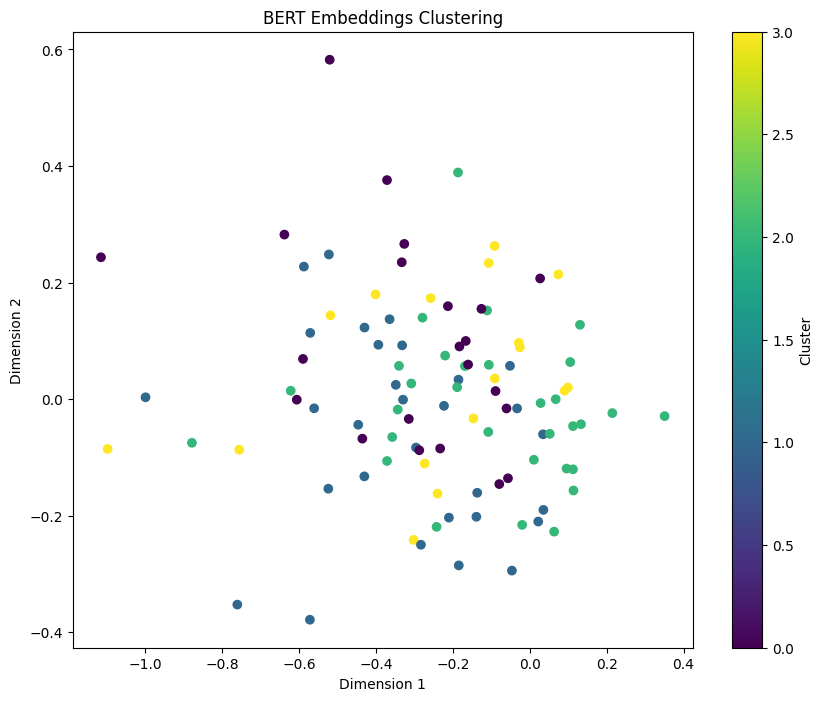

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(bert_embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(bert_embeddings[:, 0], bert_embeddings[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(label='Cluster')
plt.title('BERT Embeddings Clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


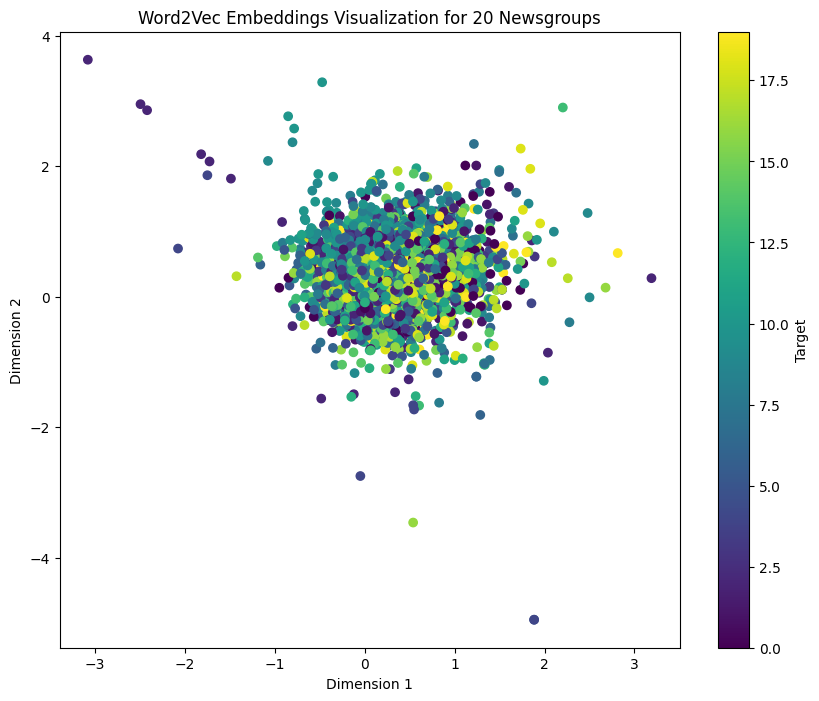

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt

newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents = newsgroups_data.data

tokenized_docs = [doc.split() for doc in documents]

word2vec_model = Word2Vec(tokenized_docs, vector_size=100, window=5, min_count=1, sg=0)
word2vec_model.train(tokenized_docs, total_examples=len(tokenized_docs), epochs=10)

doc_embeddings_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in doc if word in word2vec_model.wv]
                                             or [np.zeros(word2vec_model.vector_size)], axis=0)
                                    for doc in tokenized_docs])

target = newsgroups_data.target

x_coords = doc_embeddings_word2vec[:, 0]
y_coords = doc_embeddings_word2vec[:, 1]

plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, c=target, cmap='viridis')  # Using target labels for color mapping
plt.colorbar(label='Target')
plt.title('Word2Vec Embeddings Visualization for 20 Newsgroups')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()
